# Handling and analysis of the Enron Email Dataset - Part 2


------------------------------

## The class definitions


* Class: EnronEmailParser: Parser for the emails included in the [Enron Email Dataset](https://www.cs.cmu.edu/~./enron/).  
_Note: This particular implementation treats all recipients including to, cc and bcc recipients as same type._
* Class: EnronEmailDataset: Data handler for the Enron Email Dataset  
_Note1: It relies on the EnronEmailParser class to do the actual email parsing._  
_Note2: It uses pandas dataframes as the data storage objects._

In [1]:
%matplotlib inline
import pandas as pd
from enrondatahandling import EnronEmailDataset
import matplotlib.pyplot as plt

In [2]:
# Load and parse the enron email dataset
enronData = EnronEmailDataset('./data')

Surveyed 1702 email files
Parsed 1702 emails


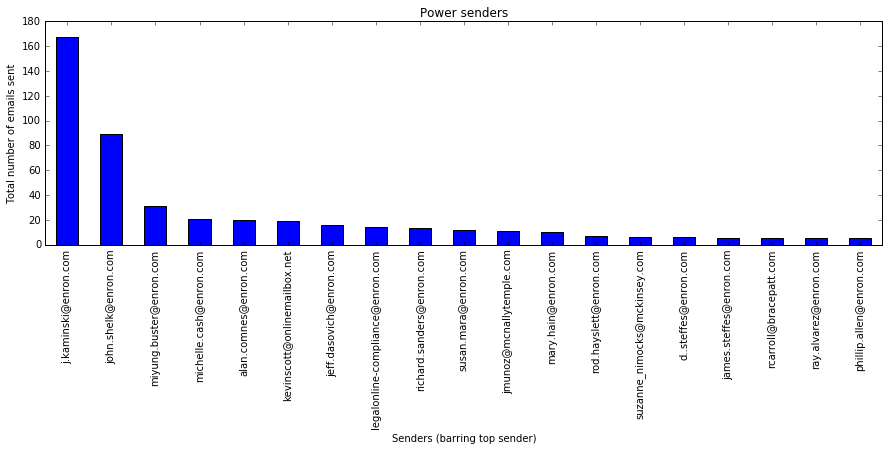

In [16]:
power_senders = (enronData
                 .emails[['sender', 'ts']]
                 .groupby('sender')
                 .count()
                 .rename(columns={'ts': 'count'})
                 .sort_values(by='count', ascending=[0])
                )
plot_top20_barring1 = power_senders[1:20].plot(kind='bar', legend=None, title="Power senders", figsize=(15, 4))
plot_top20_barring1.set_xlabel("Senders (barring top sender)")
plot_top20_barring1.set_ylabel("Total number of emails sent")

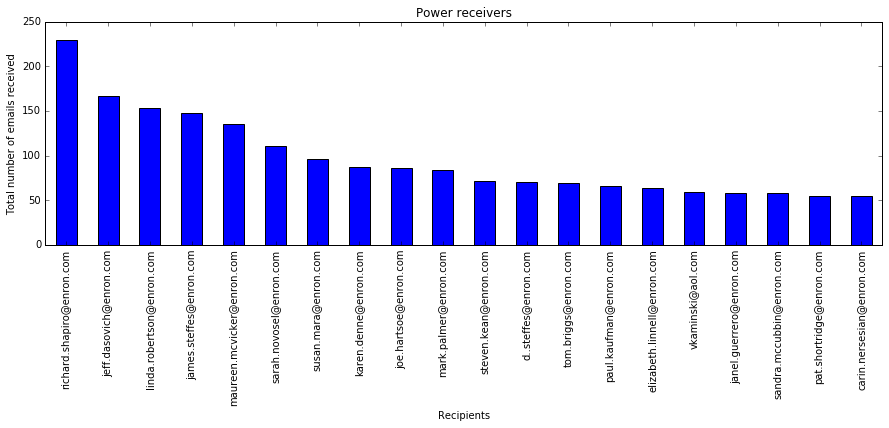

In [17]:
power_receivers = (enronData.recipients
                   .groupby('recipient')
                   .count()
                   .rename(columns={'email_id': 'count'})
                   .sort_values(by='count', ascending=[0])
                 )
plot_top20 = power_receivers[:20].plot(kind='bar', legend=None, title="Power receivers", figsize=(15, 4))
plot_top20.set_xlabel("Recipients")
plot_top20.set_ylabel("Total number of emails received")